# 0. Imports

In [19]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv()
import os

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors

In [2]:
target_col = 'expensive'

# 1. Lendo base

In [3]:
path_raw = os.getenv('PATH_TO_SPLIT')
df = pd.read_csv(path_raw, sep=',')
# df = pd.read_csv(path_raw, sep=',')

In [4]:
df = df.drop(df.columns[0], axis=1)

In [5]:
df.sample(1)

,find_condominio,find_iptu,find_m_quadrado,is_academia,is_apertamento,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_salao_festa,is_varanda,n_banheiros,n_garagens,n_quartos,expensive,Bairro
2592,800.0,0.0,85.0,0,1,0,1,0,0,0,0,0,1,1,3,0,Santo Amaro


# 2. Dividindo entre treino e teste

In [6]:
df_1 = df.copy() 

In [7]:
df_1['Bairro'] = df_1['Bairro'].astype('category')
df_1['Bairro'] = df_1['Bairro'].cat.codes

In [8]:
X = df_1.drop(columns=[target_col])
y = df_1[target_col]

# Separando os dados em treinamento(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# 3. Treinamento

## Decision Tree

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [10]:
dt = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=500)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=500, random_state=42)

Accuracy: 0.88


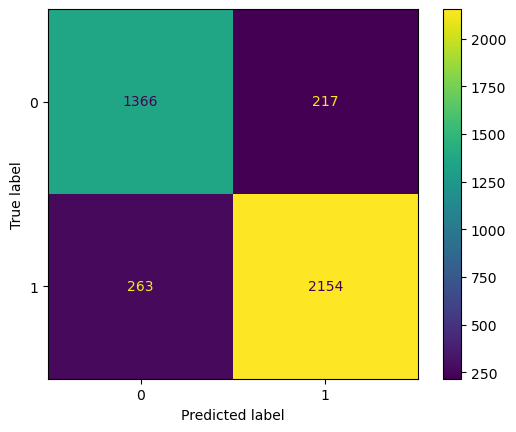

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1583
           1       0.91      0.89      0.90      2417

    accuracy                           0.88      4000
   macro avg       0.87      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred))

## Random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, y_train)

In [13]:
y_pred = rf.predict(X_test)

Accuracy: 0.90


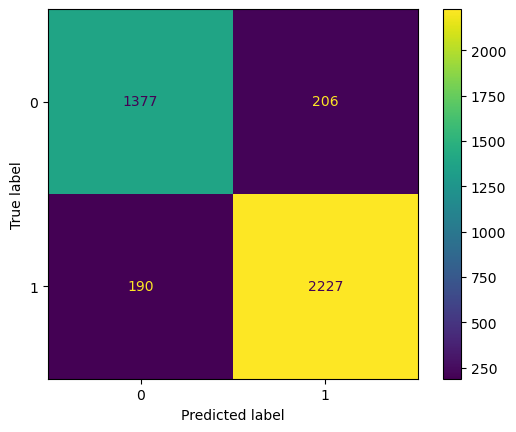

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1583
           1       0.92      0.92      0.92      2417

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred))

## Log regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# lr = make_pipeline(StandardScaler(), LogisticRegression())

lr = LogisticRegression(max_iter = 20000)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

Accuracy: 0.77


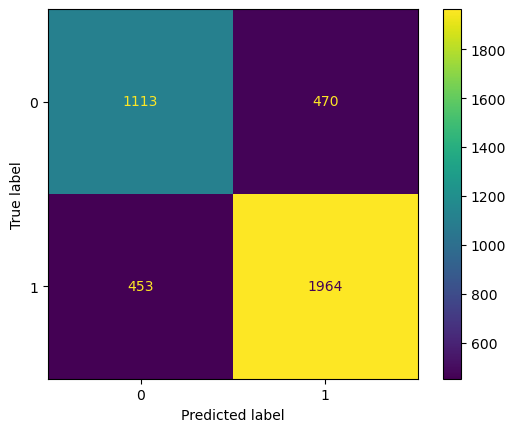

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1583
           1       0.81      0.81      0.81      2417

    accuracy                           0.77      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.77      0.77      0.77      4000



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred))

## 4. Interpretabilidade - Analisando Random Forest

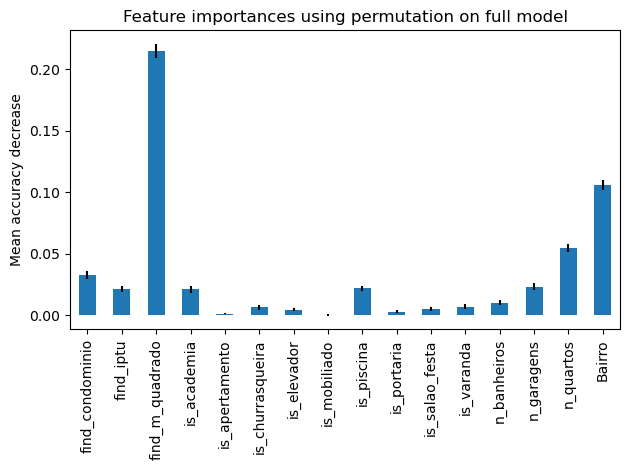

In [16]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(rf, X_test, y_test ,n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Olhando o PFI podemos ver algums comportamentos esperados, como a alta correlação de m^2 e o bairro.

A correlação com bairro é interessante pois vemos que o modelo utilizou bem a característica intríseca de cada bairro(utilizando para achar o melhor split em cada árvore que foi sorteado essa variável com um sample aleatório)

vemos que apenas 63 dos 79 bairros apareceram na base de teste, mesmo assim continuar importante como um todo

In [32]:
len(df['Bairro'].unique())

79

In [29]:
len(X_test['Bairro'].unique())

63

In [49]:
display.pd_results[0]['values'][0][np.argmax(display.pd_results[0]['average'][0])]

9

Vendo o PDP da coluna bairro conseguimos ver isso claramente, como que fica a média do predict_proba(classe 1 - imóvel caro) para as intâncias quando alteramos o bairro

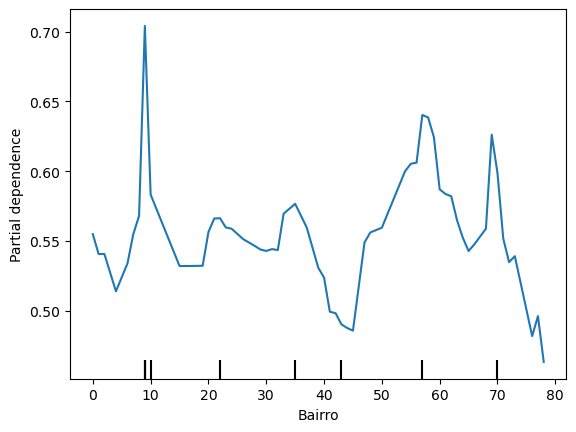

In [17]:
from sklearn.inspection import PartialDependenceDisplay

display  = PartialDependenceDisplay.from_estimator(rf, X_test, [15])

In [50]:
df_1['Bairro'].value_counts()

Bairro
9     7553
41    1140
48    1045
20     999
76     882
      ... 
25       1
49       1
75       1
53       1
14       1
Name: count, Length: 79, dtype: int64

In [51]:
df['Bairro'].value_counts()

Bairro
Boa Viagem           7553
Imbiribeira          1140
Madalena             1045
Casa Amarela          999
Várzea                882
                     ... 
Coqueiral               1
Mangueira               1
Vasco da Gama           1
Nova Descoberta         1
Brejo de Beberibe       1
Name: count, Length: 79, dtype: int64

Interessante reparar que imóveis em Boa Viagem o modelo aprendeu que tem mais probabilidade de pertencer a classe 1(ser 'caro')  

Acredito que esse modelo aprendeu bem a separar um bairro do outro, ja que vemos rapidas mudanças de um para o outro e nenhum sentido crescente ou decrecente.

Quer dizer, alguns bairros ajudam mais que outros a definir o preço do lugar, alguns bairros apresentam muitas residencias caras, enquanto outros, so apresentam residencias baratas. Além disso, alguns são heterogeneos em sua composição e por isso.

Como vimos, o metro quadrado é uma feature importante, mas ela parece ser disparado a mais importante

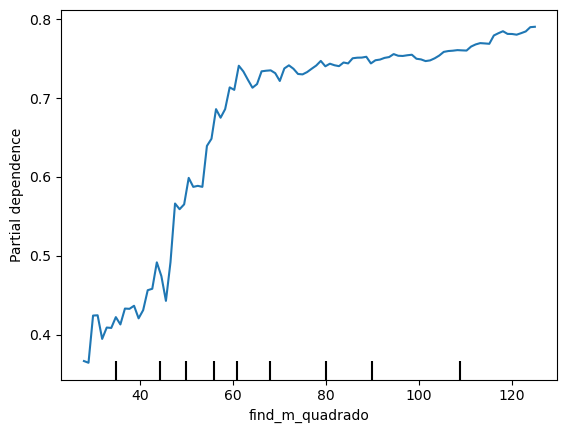

In [18]:
from sklearn.inspection import PartialDependenceDisplay

display  = PartialDependenceDisplay.from_estimator(rf, X_test, [2])

Vemos uma parte baixa no grafico, do inicio até 50. Quer dizer que quando o metro quadrado é baixo, o modelo diz que a probabilidade de pertencer a classe 1(imóvel caro) é mais baixa, Enquanto se um apartamento tem mais de 60 m^2 ele definitivamente é caro.

o fato do metro quadrado ser tão importante, parece ter diminuido a importancia de features que claramente deveria ajudar como condominio e IPTU

## Podemos fazer uma analise aqui sobre a parte mais dificil do dataset
    - Utilizando o método de vizinhança para calcular dificuldade das intâncias
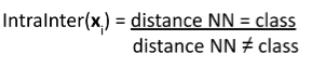
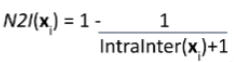
    
    - As instâncias mais difíceis vão ser as com o n2i acima da média

In [22]:
def calculate_intrainter(X, y, k=5):
    y = np.array(y)  
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nn.kneighbors(X)

    intrainter_values = []
    
    for i, neighbors in enumerate(indices):
        same_class_distances = []
        diff_class_distances = []

        for neighbor in neighbors[1:]: 
            if y[neighbor] == y[i]:
                same_class_distances.append(distances[i][neighbors.tolist().index(neighbor)])
            else:
                diff_class_distances.append(distances[i][neighbors.tolist().index(neighbor)])

        if len(same_class_distances) > 0 and len(diff_class_distances) > 0:
            intrainter = (sum(same_class_distances) / len(same_class_distances)) / (sum(diff_class_distances) / len(diff_class_distances))
        else:
            intrainter = float('inf')  

        intrainter_values.append(intrainter)

    return np.array(intrainter_values)

def calculate_n2i(intrainter_values):
    n2i_values = 1 - (1 / (intrainter_values + 1))
    return n2i_values


intrainter_values = calculate_intrainter(X_test, y_test, k=5)
n2i_values = calculate_n2i(intrainter_values)


C:\Users\Thamires\AppData\Local\Temp\ipykernel_10064\2306191966.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  intrainter = (sum(same_class_distances) / len(same_class_distances)) / (sum(diff_class_distances) / len(diff_class_distances))
C:\Users\Thamires\AppData\Local\Temp\ipykernel_10064\2306191966.py:19: RuntimeWarning: invalid value encountered in scalar divide
  intrainter = (sum(same_class_distances) / len(same_class_distances)) / (sum(diff_class_distances) / len(diff_class_distances))


In [36]:
df_1['n2i'] = pd.Series(n2i_values)
df_1['INST_HARD'] = df_1['n2i'].apply(lambda x: 1 if x>pd.Series(n2i_values).mean() else 0)
casa_dificil_df = df_1[(df_1['INST_HARD'] == 1)]

In [42]:
X_dificil = casa_dificil_df.drop(columns=[target_col, 'n2i', 'INST_HARD'])
y_dificil = casa_dificil_df[target_col]

In [43]:
X_dificil['find_m_quadrado'].describe()

count    2405.000000
mean       67.402495
std        28.444727
min        10.000000
25%        46.000000
50%        61.000000
75%        86.000000
max       152.000000
Name: find_m_quadrado, dtype: float64

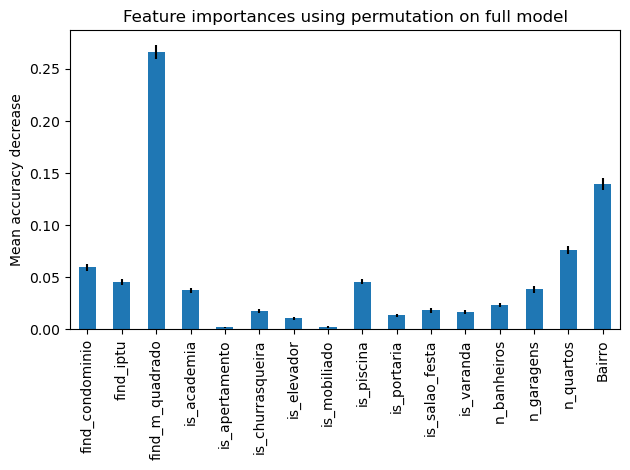

In [44]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(rf, X_dificil, y_dificil, n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

- Abaixo vemos o PFI para a base completa, vemos que não muda muito a importância de cada feature para as instâncias mais difíceis

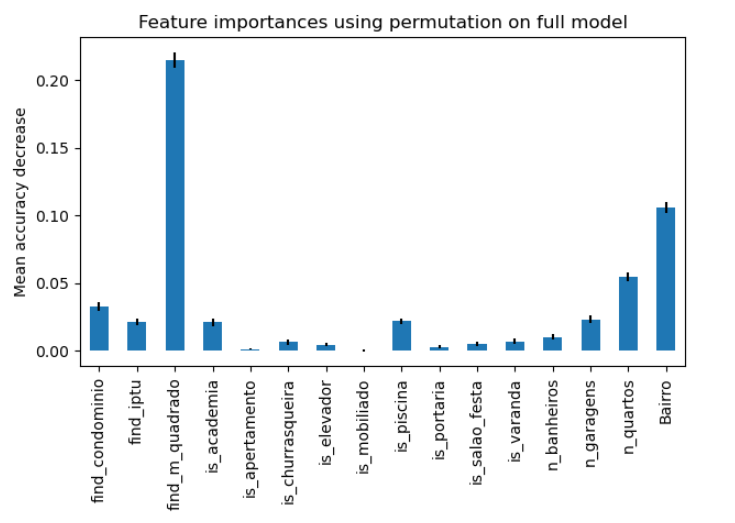

# Confiabilidade

- Para confiabilidade do modelo, vamos definir um alpha que vai regular a zona cinza dos nossos scores (região mais incerta).
- Pensei em separar a régua de scores em duas regiões: uma região onde temos boa confiança sobre nosso score (as pontas) e uma região onde temos incerteza:
    1. Se `score < (0.5 - alpha)/(1 - alpha)`, então o peso do registro = 0. **Ponta esquerda**
    2. Se `score > (0.5 + alpha)/(1 - alpha)`, então o peso do registro = 0. **Ponta direita**
    3. Caso contrário, o peso do registro = 1. **"Meio", esta é a faixa que vamos avaliar como muda a área sob a curva ROC(métrica robusta a escolha do ponto de corte)**

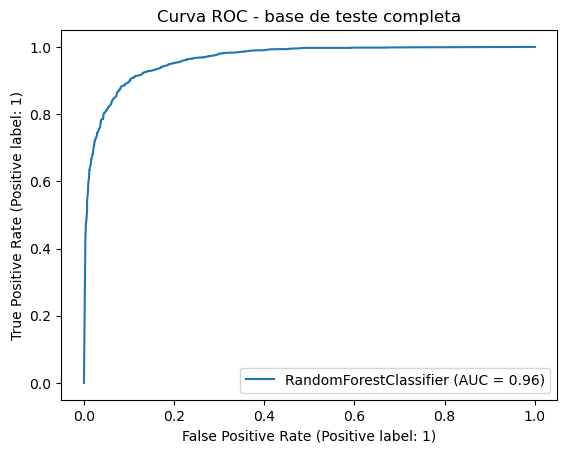

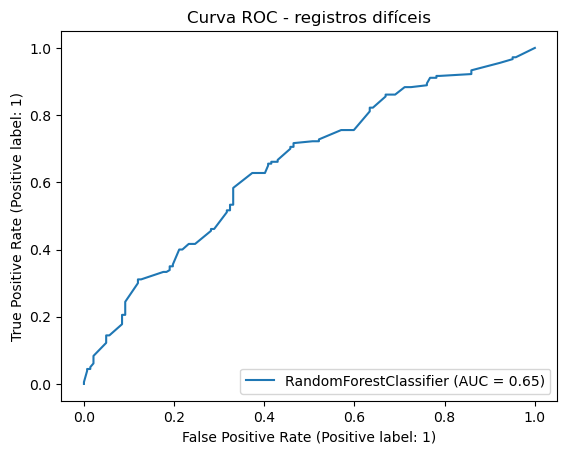

In [53]:
alpha = 0.1

scores = rf.predict_proba(X_test)[:, 1]

left_limit = (0.5 - alpha) / (1 - alpha)
right_limit = (0.5 + alpha) / (1 - alpha)
flags = (scores >= left_limit) & (scores <= right_limit)

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Curva ROC - base de teste completa")
plt.show()

X_test_hard = X_test[flags]
y_test_hard = y_test[flags]

RocCurveDisplay.from_estimator(rf, X_test_hard, y_test_hard)
plt.title("Curva ROC - registros difíceis")
plt.show()


- vemos que temos uma queda substancial na AUC quando pegamos os registros difíceis. Isso é crucial, pois poderíamos, por exemplo, fazer um modelo separado apenas para esses registros incertos para melhorar essa AUC.

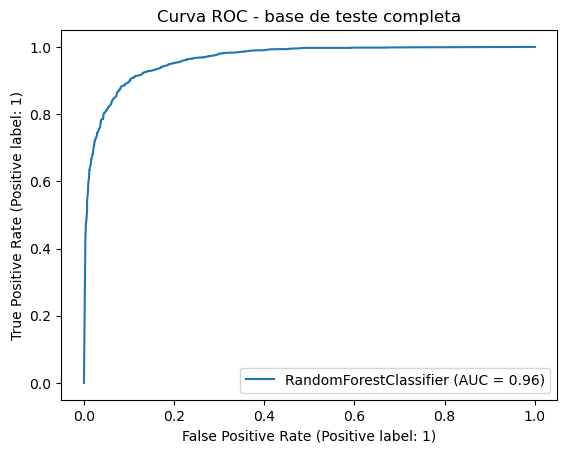

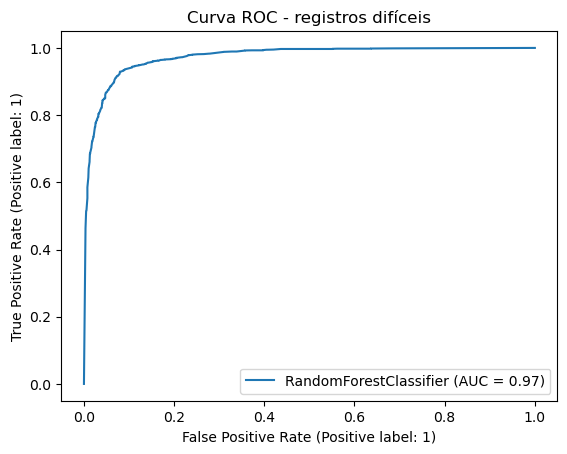

In [54]:
alpha = 0.1

scores = rf.predict_proba(X_test)[:, 1]

left_limit = (0.5 - alpha) / (1 - alpha)
right_limit = (0.5 + alpha) / (1 - alpha)
flags = (scores >= left_limit) & (scores <= right_limit)

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Curva ROC - base de teste completa")
plt.show()

X_test_hard = X_test[~flags]
y_test_hard = y_test[~flags]

RocCurveDisplay.from_estimator(rf, X_test_hard, y_test_hard)
plt.title("Curva ROC - registros difíceis")
plt.show()


- vemos também que o caso contrário é válido na AUC quando pegamos os registros menos incertos(apensar o auc já está bem perto de 1.0). Temos o aumento de 0.01 p.p